In [1]:
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from optimization import (SequenceSignal, 
                          transformer_model, 
                          train_val_loops)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (precision_score, recall_score, auc, 
                             precision_recall_curve, PrecisionRecallDisplay)

In [2]:
# Global variables
DATA_DIR=Path('../ML_datasets/dELSs_data/')
X_TRAIN_PATH = DATA_DIR.joinpath('dataset_1kb_dELSs_train_augmented_encoding.npy')
Y_TRAIN_PATH = DATA_DIR.joinpath('train_target.npy')
X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_dELSs_val_encoding.npy')
Y_VAL_PATH = DATA_DIR.joinpath('val_target.npy')
N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]
N_TRAIN_EXAMPLES = np.load(Y_TRAIN_PATH).shape[0]

BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
                                          Y_TRAIN_PATH, 
                                          X_VAL_PATH, 
                                          Y_VAL_PATH, 
                                          BATCH_SIZE, 
                                          device = DEVICE)

In [3]:
N_EPOCHS = 30
PATIENCE = 20
OUTPUT_SHAPE = 9

epsilon = 1e-6
n_pos = np.load(Y_TRAIN_PATH).sum(axis=0)
n_neg = (1.0 - np.load(Y_TRAIN_PATH)).sum(axis=0)
pos_weight = n_neg / (n_pos + epsilon)
pos_weight = torch.Tensor(pos_weight).to(DEVICE)

CRITERION = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
CHECKPOINT_NAME = DATA_DIR.joinpath('best_model_dELSs.pth')
PRETRAINED_WEIGHTS = '../ML_datasets/ATAC_data/ATAC_transformer.pth'
USE_PRETRAIN = False


model = transformer_model.TransformerCNNMixtureModel(n_conv_layers = 4, 
                                                     n_filters = [256, 60, 60, 120], 
                                                     kernel_sizes = [7, 3, 5, 3], 
                                                     dilation = [1, 1, 1, 1], 
                                                     drop_conv = 0.1, 
                                                     n_fc_layers = 2, 
                                                     drop_fc = 0.4, 
                                                     n_neurons = [256, 256], 
                                                     output_size = OUTPUT_SHAPE, 
                                                     drop_transformer=0.2, 
                                                     input_size=4, 
                                                     n_encoder_layers = 2, 
                                                     n_heads=8, 
                                                     n_transformer_FC_layers=256)

model.to(device=DEVICE)

if USE_PRETRAIN:
    training_state = torch.load(PRETRAINED_WEIGHTS, 
                                weights_only = True, 
                                map_location = DEVICE)
    model.load_state_dict(training_state['network'])

summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [4]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 5e-4, weight_decay = 1e-4)

In [5]:
if not os.path.exists(CHECKPOINT_NAME):
    
    output = train_val_loops.train_N_epochs(model, optimizer, 
                                            criterion = CRITERION, 
                                            train_loader = dataloaders[0], 
                                            valid_loader = dataloaders[1], 
                                            num_epochs = N_EPOCHS, 
                                            patience = PATIENCE, 
                                            model_path = CHECKPOINT_NAME, 
                                            lr_scheduler = None, 
                                            DEVICE = DEVICE)
else:
    
    training_state = torch.load(CHECKPOINT_NAME, 
                                weights_only = True, 
                                map_location = DEVICE)
    
    model.load_state_dict(training_state['network'])

In [6]:
Y_PREDICT_PATH = DATA_DIR.joinpath('y_predict_dELSs.npy')

model.eval()
y_predict = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(inputs)
        y_true[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = labels

y_true_array = y_true.cpu().numpy()
print(CRITERION(y_predict, y_true))
y_predict = nn.functional.softmax(y_predict, dim=1)
y_predict_array = (y_predict).cpu().numpy()
np.save(Y_PREDICT_PATH, y_predict_array)

tensor(0.7709)


0.3103976556646421
0.5295784709398205
0.4803074820597076
0.6186870465529102
0.6323565758485786
0.5813648293425264
0.5526015081515869
0.6552280859722509
0.3047851473631451


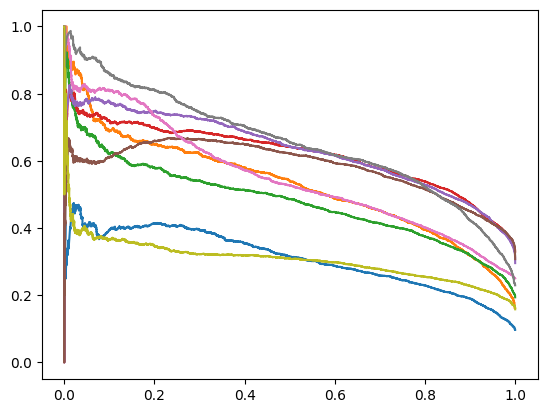

In [7]:
for j in range(OUTPUT_SHAPE):
    y, x, _ = precision_recall_curve(y_true_array[:, j], y_predict_array[:, j])
    plt.plot(x, y)
    print(auc(x, y))